In [29]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio

sys.path.insert(0,'../')
from PhicoreModules import parse_genbank, mean, median, mode, visualise

In [30]:
def coding_regions(entry: Bio.SeqRecord.SeqRecord, verbose: bool = False) -> list[int]:
    """
    calculate a list of ints of the regions that are coding for the record
    
    :param record: The genbank record entry (ie. one sequence record)
    :param verbose: more output
    :return : a list of 1's and 0's. 1: the base is encoding. 0: the base is not
    """
    
    seqlen = len(entry.seq)
    coding = [0 for i in range(seqlen)]
    fn = {'CDS': 0, 'tRNA': 0}
    for feat in entry.features:
        if feat.type != 'CDS' and feat.type != 'tRNA':
            print(f"Skipped feature of type: {feat.type}", file=sys.stderr)
            continue
        fn[feat.type] = fn.get(feat.type, 0) + 1
        (start, stop, strand) = (feat.location.start.position, feat.location.end.position, feat.strand)
        for i in range(start, stop):
            coding[i] = 1
    if verbose:
        print(f"Found {fn['CDS']} CDS and {fn['tRNA']} tRNA", file=sys.stderr)
    return coding

In [31]:
def coding_stats(coding: list[int], window: int, step: int, verbose: bool = False) -> dict[str, int]:
    """
    Calculate the statistics for this coding window
    :param coding: the list of coding/not coding regions(a list of 1's and 0's)
    :param window: the window to calculate the average across
    :param step: the step size between windows
    :param verbose: more output
    :return : a dictionary summaring the statistics
    """
    
    winbeg = 0
    allcd = {}

    while winbeg + step + window < len(coding):
        winend = winbeg + window
        cd = sum(coding[winbeg:winend])/window
        allcd[winbeg] = cd
        winbeg += step
    
    return {
        'mean': sum(allcd.values())/len(allcd.values()),
        'median' : median(list(allcd.values())),
        'mode': mode(allcd.values()),
        'minimum': min(allcd.values()),
        'maximum': max(allcd.values()),
        'all': allcd
    }
        

In [32]:
def calc_coding_density(filestub, gbkdir = '../genbank/'):
    codden = pd.DataFrame()
    data = {}
    coding = []
    for file in os.listdir(gbkdir):
        if not filestub in file:
            continue
        seq = parse_genbank(os.path.join(gbkdir, file))

        for entry in seq.records:
            coding = coding_regions(entry, verbose=True)
            stats = coding_stats(coding, 5000, 150)
            data[file] = [stats['mean'], stats['median'], stats['mode'], stats['minimum'], stats['maximum']]
            if codden.empty:
                codden = pd.DataFrame.from_dict(stats['all'], orient='index',columns=[file]).reset_index()
                codden = codden.rename(columns={'index': 'x'})
            else:
                codden[file] = codden['x'].map(stats['all'])

    return pd.DataFrame.from_dict(data, orient='index', columns=['mean', 'median', 'mode', 'minimum', 'maximum']), codden

In [37]:
summary, cod = calc_coding_density(filestub='Bc01.fasta')
summary

/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 19 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 20 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 119 CDS and 22 tRNA
/home/nala0006/miniconda3/envs/not

,mean,median,mode,minimum,maximum
Bc01.fasta-TAA.gbk,0.966073,0.9786,1.0000,0.8396,1.0
Bc01.fasta-TAG-TAA.gbk,0.967485,0.9828,0.9988,0.7910,1.0
Bc01.fasta-TAG-TGA-TAA.gbk,0.964977,0.9804,0.9996,0.7530,1.0
Bc01.fasta-TAG-TGA.gbk,0.974917,0.9878,1.0000,0.8438,1.0
Bc01.fasta-TAG.gbk,0.974220,0.9786,1.0000,0.9128,1.0
Bc01.fasta-TGA-TAA.gbk,0.968365,0.9864,1.0000,0.7716,1.0
Bc01.fasta-TGA.gbk,0.981746,0.9892,1.0000,0.9366,1.0


<AxesSubplot:>

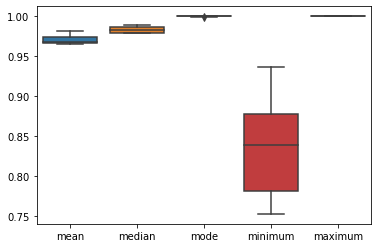

In [34]:
sns.boxplot(data=summary)

In [35]:
summary, cod = calc_coding_density(filestub='UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta')

/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 141 CDS and 5 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 284 CDS and 4 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 277 CDS and 4 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packag

In [25]:
summary

,mean,median,mode,minimum,maximum
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAA.gbk,0.950219,0.9615,1.0000,0.7265,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TAA.gbk,0.809911,0.8140,0.9715,0.3990,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA-TAA.gbk,0.781408,0.7935,0.9715,0.4190,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG-TGA.gbk,0.884664,0.8870,1.0000,0.6955,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TAG.gbk,0.933533,0.9400,1.0000,0.7670,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk,0.952761,0.9740,1.0000,0.6600,1.0
UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA.gbk,0.977024,1.0000,1.0000,0.8745,1.0


<AxesSubplot:>

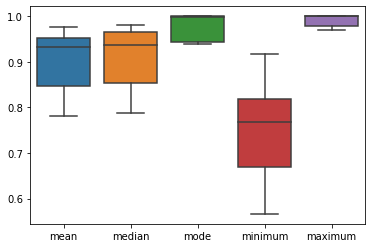

In [36]:
sns.boxplot(data=summary)

In [26]:
summary, cd = calc_coding_density(filestub='Bc01.fasta')

/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 19 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 20 tRNA
/home/nala0006/miniconda3/envs/notebook_env/lib/python3.10/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 119 CDS and 22 tRNA
/home/nala0006/miniconda3/envs/not

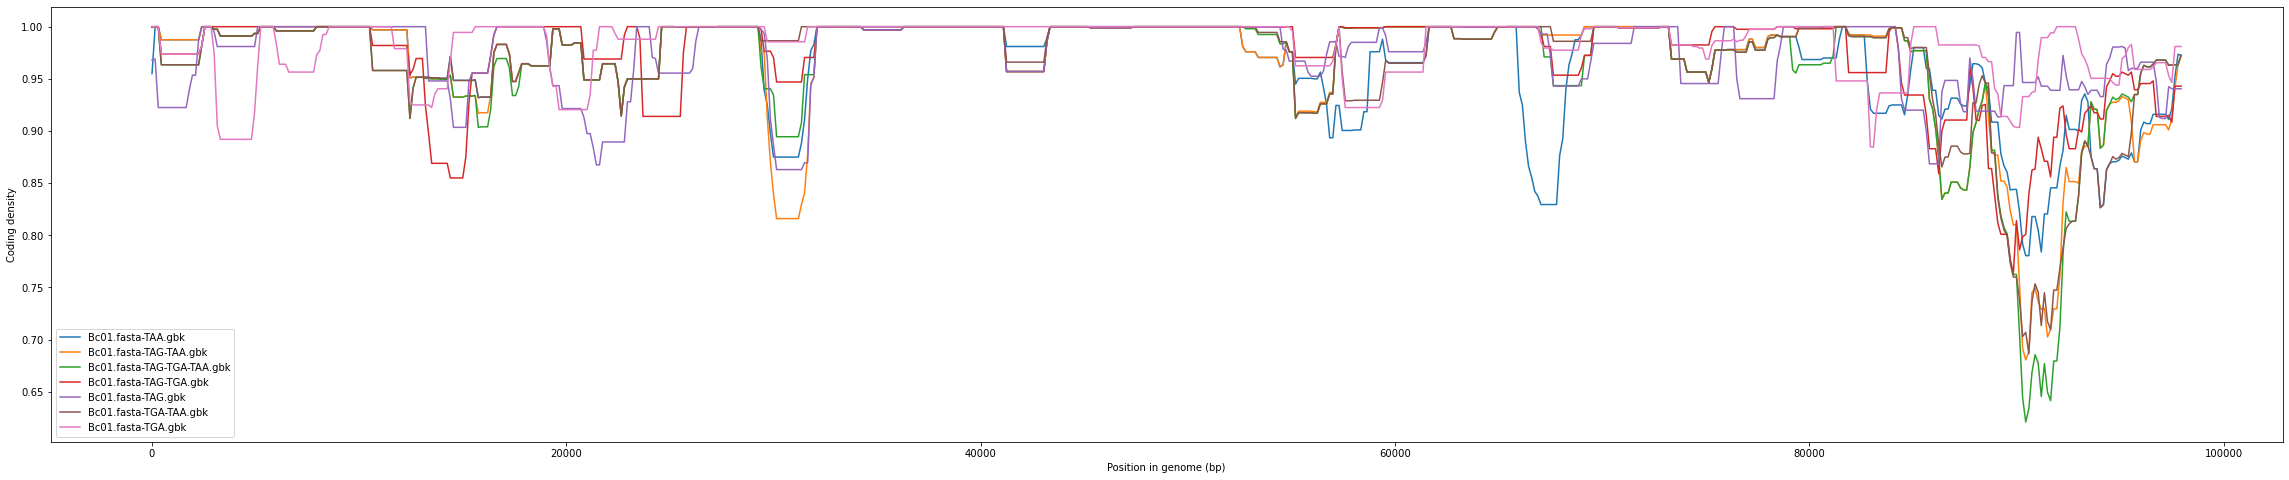

In [10]:
g = cd.plot(x='x', figsize=(40, 8))
t = g.set_xlabel('Position in genome (bp)')
t = g.set_ylabel('Coding density')
plt.savefig('coding_density.png')

/home/edwa0468/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 141 CDS and 5 tRNA
Skipped feature of type: source
Found 284 CDS and 4 tRNA
Skipped feature of type: source
Found 277 CDS and 4 tRNA
Skipped feature of type: source
Found 289 CDS and 3 tRNA
Skipped feature of type: source
Found 212 CDS and 1 tRNA
Skipped feature of type: source
Found 137 CDS and 5 tRNA
Skipped feature of type: source
Found 101 CDS and 1 tRNA


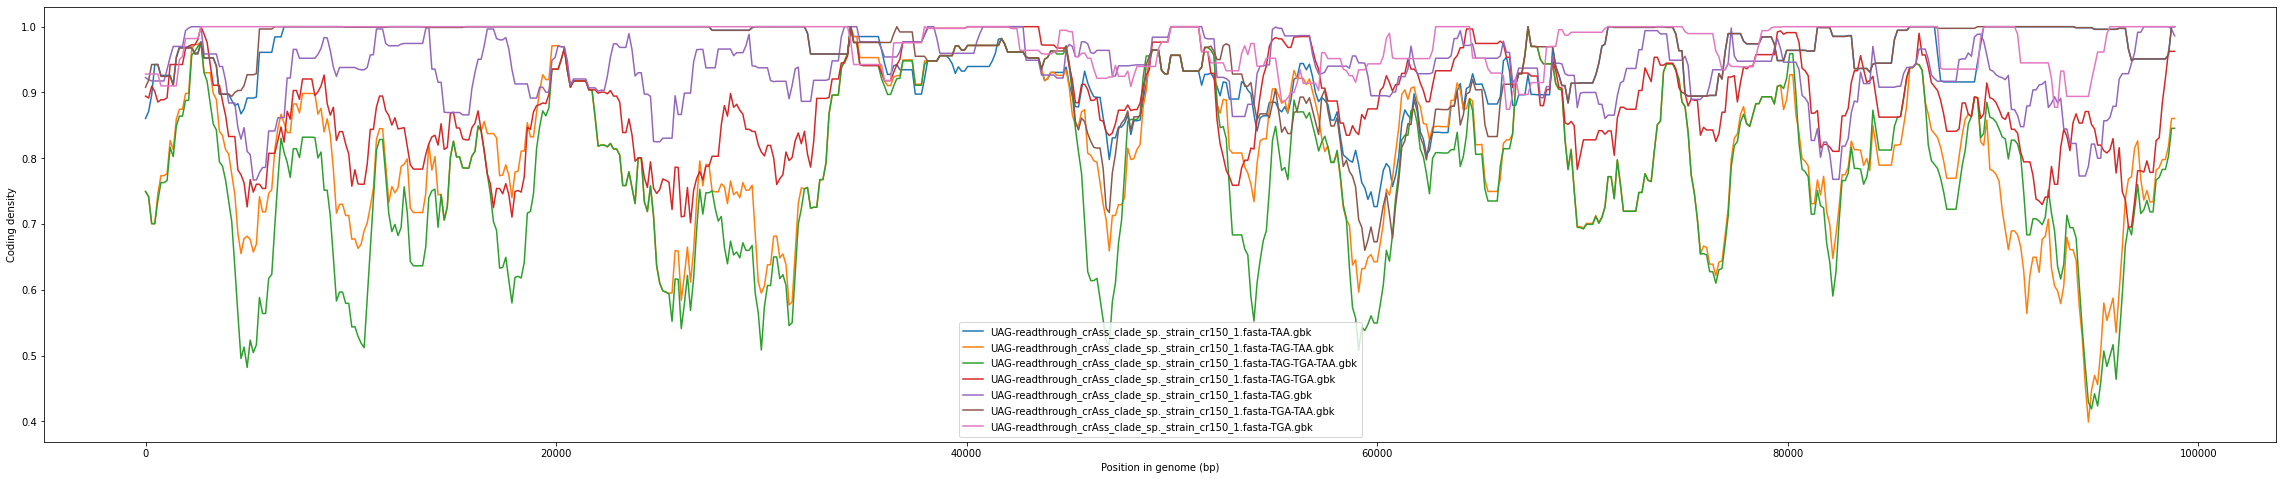

In [10]:
summary, cd = calc_coding_density(filestub='UAG-readthrough_crAss_clade')
g = cd.plot(x='x', figsize=(40, 8))
t = g.set_xlabel('Position in genome (bp)')
t = g.set_ylabel('Coding density')
plt.savefig('coding_density.png')